# Лабораторная работа №4. Корреляционный анализ

> Вариант № 7

**Распределения**:

$X \sim N(-1, 2)$

$Y \sim R(-2, 0)$

Объём выборок $n$ &mdash; 100


In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Немного магии для того, чтобы рисунки стали больше
import pylab
pylab.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams.update({'font.size': 22})

# Вспомогательные классы и функции, определённые тут же (см. репозиторий)
# https://github.com/BobNobrain/matstat-labs/tree/master/s
from s import Sample, HTable
from s.utils import table, printf, load_styles
load_styles()

## 1. Исходные данные

In [2]:
X = stats.norm(-1, 2**0.5)
Y = stats.uniform(-2, 2)
n = 100

print('Характеристики наблюдаемых случайных величин:')
table(
    ['СВ', 'Распределение', 'Параметры', '$m_i$', '$\\sigma_i^2$', '$n_i$'],
    [
        ['X', 'N', '$m=-1, \\sigma,2=2$', X.mean(), X.var(), n],
        ['Y', 'R', '$a=-2, b=0$', Y.mean(), Y.var(), n]
    ]
)

Характеристики наблюдаемых случайных величин:


СВ,Распределение,Параметры,$m_i$,$\sigma_i^2$,$n_i$
X,N,"$m=-1, \sigma,2=2$",-1.0,2.0000000000000004,100
Y,R,"$a=-2, b=0$",-1.0,0.3333333333333333,100


In [3]:
x = Sample.from_distribution("x", X, count=n)
y = Sample.from_distribution("y", Y, count=n)

print('Выборочные характеристики:')
table(
    ['СВ', 'Среднее $\\overline{x_i}$', '$s^2_i$', '$s_i$'],
    [
        [
            s._name,
            round(s.mean(), 4),
            round(s.s() ** 2, 4),
            round(s.s(), 4)
        ] for s in [x, y]
    ]
)

Выборочные характеристики:


СВ,Среднее $\overline{x_i}$,$s^2_i$,$s_i$
x,-0.8354,1.8634,1.3651
y,-1.0524,0.3509,0.5923


In [4]:
def pierson(x, y):
    r, _ = stats.pearsonr(x, y)
    return r

def spirmen(x, y):
    rho, _ = stats.spearmanr(x, y)
    return rho

def kendell(x, y):
    tau, _ = stats.kendalltau(x, y)
    return tau

In [5]:
t = HTable(rows=2, cols=6, head_rows=1)
t.fill(row=0, head=True, content=[
    'СВ',
    'Среднее $\\overline{x_i}$',
    'Оценка дисперсии $s^2_i$',
    'КК по Пирсону $r_{xy}$',
    'КК по Спирмену $\\rho_{xy}$',
    'КК по Кендаллу $\\tau_{xy}$'
])
t.fill(col=0, content=['X', 'Y'])
t.map_col(0, lambda c: c.add_class('head'))
t.fill(
    col = 1, 
    content = [ round(sample.mean(), 4) for sample in [x, y] ]
)
t.fill(
    col = 2,
    content = [ round(sample.s() ** 2, 4) for sample in [x, y] ]
)

t.map_row(0, lambda c: c.span(rowspan=2).add_class('text-center'), limits=(3, 6))

t.fill(row=0, content=[
    None,
    None,
    None,
    pierson(x.data(), y.data()),
    spirmen(x.data(), y.data()),
    kendell(x.data(), y.data())
])

print('Выборочные характеристики:')
t.show()


Выборочные характеристики:


In [6]:
print('Проверка значимости коэффициентов корреляции:')

alpha = 0.05

def pearson_0_test(text, x, y, expected):
    r, p_val = stats.pearsonr(x.data(),y.data())
    z = r * np.sqrt(n-2)/np.sqrt(1-r**2)
    result = abs(z) < stats.t.ppf(1-alpha/2, n - 2)
    decision = '$H_0$' if result else '$H_1$'
    return text, p_val, decision, "-" if result == expected else ("Ошибка первого рода" if expected else "Ошибка второго рода")

def spearman_0_test(text, x, y, expected):
    rho, p_val = stats.spearmanr(x.data(), y.data())
    z = rho / np.sqrt(1 - rho) * np.sqrt(n - 2)
    result = abs(z) < stats.t.ppf(1-alpha/2, n - 2)
    decision = '$H_0$' if result else '$H_1$'
    return text, p_val, decision, "-" if result == expected else ("Ошибка первого рода" if expected else "Ошибка второго рода")

def kendall_0_test(text, x, y, expected):
    tau, p_val = stats.kendalltau(x.data(), y.data())
    z = tau * np.sqrt(9*n*(n+1)/(2*(2*n+5)))
    result = abs(z) < stats.norm.ppf(1-alpha/2, 0, 1)
    decision = '$H_0$' if result else '$H_1$'
    return text, p_val, decision, "-" if result == expected else ("Ошибка первого рода" if expected else "Ошибка второго рода")

table(
    [
        'Статистическая гипотеза $H_0$',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        pearson_0_test('$H_0: r_{XY} = 0$', x, y, True),
        spearman_0_test('$H_0: \\rho_{XY} = 0$', x, y, True),
        kendall_0_test('$H_0: \\tau_{XY} = 0$', x, y, True),
    ]
)

Проверка значимости коэффициентов корреляции:


Статистическая гипотеза $H_0$,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
$H_0: r_{XY} = 0$,0.15145316642839,$H_0$,-
$H_0: \rho_{XY} = 0$,0.21696469369766563,$H_0$,-
$H_0: \tau_{XY} = 0$,0.20033763743143973,$H_0$,-


## 2. Визуальное представление двумерной выборки

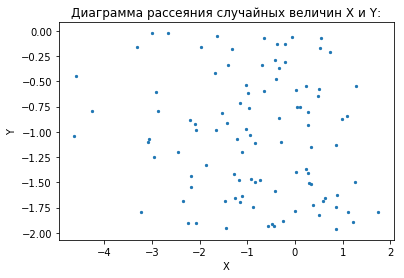

In [7]:
fig, ax = plt.subplots()

ax.set_title('Диаграмма рассеяния случайных величин X и Y:')
ax.set_xlabel('X')
ax.set_ylabel('Y');

ax.scatter(x.data(), y.data(), s=5);


## 3. Проверка независимости методом таблиц сопряженности

Статистическая гипотеза:

$$ H_0: F_Y(y | X \in \Delta_1) = ... = F_Y(y | X \in \Delta_k) = F_Y(y) $$

In [8]:
import math
from functools import *
x_delta = (math.ceil(x.max()) - math.floor(x.min()))/5
x_start = math.floor(x.min())
y_delta = (math.ceil(y.max()) - math.floor(y.min()))/5
y_start = math.floor(y.min())

zipped = list(zip(x.data(), y.data()))
matrix = []

def experimental_theoretical_cell(zipped, xbegin, xend, ybegin, yend):
    experimental = len(list(filter(
        lambda e: (
            xbegin <= e[0] < xend and 
            ybegin <= e[1] < yend
        ),
        zipped
    )))
    filtredx = len(list(filter(
        lambda e: xbegin <= e[0] < xend,
        zipped
    )))
    filtredy = len(list(filter(
        lambda e: ybegin <= e[1] < yend,
        zipped
    )))
    theoretical = filtredx*filtredy/len(zipped)
    return (experimental, theoretical)
                     
def table_row(num):
    begin = x_start + (num - 1) * x_delta
    end = x_start + num * x_delta
    res = ['$\\Delta_{} = [{:.01f};{:.01f})$'.format(num, begin, end)]
    for y_num in range(1, 6):
        y_begin = y_start + (y_num - 1) * y_delta
        y_end = y_start + y_num * y_delta
        res.append(experimental_theoretical_cell(zipped, begin, end, y_begin, y_end))
    matrix.append(res[1:])
    return res[:]

def table_column_name(num):
    return '$[{:.01f};{:.01f})$'.format(y_start + (num - 1) * y_delta, y_start + num * y_delta)
        
print('Эмпирическая/теоретическая таблицы сопряженности:')
table(
    [
        'X \\ Y',
        table_column_name(1),
        table_column_name(2),
        table_column_name(3),
        table_column_name(4),
        table_column_name(5),
    ],
    [ table_row(row) for row in range(1,6) ]
)

Эмпирическая/теоретическая таблицы сопряженности:


X \ Y,$[-2.0;-1.6)$,$[-1.6;-1.2)$,$[-1.2;-0.8)$,$[-0.8;-0.4)$,$[-0.4;0.0)$
$\Delta_1 = [-5.0;-3.6)$,"(0, 0.75)","(0, 0.48)","(1, 0.69)","(2, 0.54)","(0, 0.54)"
$\Delta_2 = [-3.6;-2.2)$,"(3, 3.0)","(1, 1.92)","(3, 2.76)","(2, 2.16)","(3, 2.16)"
$\Delta_3 = [-2.2;-0.8)$,"(7, 8.5)","(7, 5.44)","(11, 7.82)","(5, 6.12)","(4, 6.12)"
$\Delta_4 = [-0.8;0.6)$,"(8, 9.5)","(7, 6.08)","(5, 8.74)","(8, 6.84)","(10, 6.84)"
$\Delta_5 = [0.6;2.0)$,"(7, 3.25)","(1, 2.08)","(3, 2.99)","(1, 2.34)","(1, 2.34)"


In [9]:
alpha = 0.05
z = 0;
for i in range(5):
    for j in range(5):
         z += (matrix[i][j][0] - matrix[i][j][1])**2/matrix[i][j][1]
crit = stats.chi2.ppf(1-alpha, (5 - 1)*(5 - 1))
result = z < crit
decision = 'H0' if result else 'H1'
p_val = 1 - stats.chi2.cdf(z, (5-1)*(5-1))
expected = False
error = "-" if result == expected else ("Ошибка первого рода" if expected else "Ошибка второго рода")
table(
    [
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        [z, p_val, decision, error]
    ]
)

Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
19.656954520840976,0.2360701512135841,H0,Ошибка второго рода


## 4. Исследование корреляционной связи

Случайная величина $ U = \lambda X + (1 - \lambda) Y, \lambda \in [0; 1]$

Случайная величина $ V = \lambda X^3 + (1 - \lambda) Y^3, \lambda \in [0; 1]$

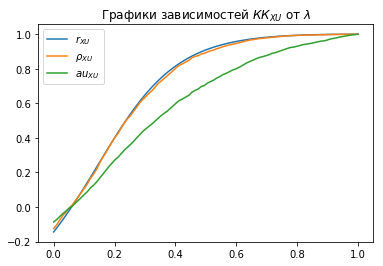

In [10]:
lambda_values = np.linspace(0, 1, 100)

def u(l, x, y):
    return l * x.data() + (1 - l) * y.data()

fig, ax = plt.subplots()
ax.set_title('Графики зависимостей $КК_{XU}$ от $\\lambda$')

pierson_values = [
    pierson(x.data(), u(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, pierson_values, label='$r_{XU}$')

spirmen_values = [
    spirmen(x.data(), u(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, spirmen_values, label='$\\rho_{XU}$')

kendell_values = [
    kendell(x.data(), u(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, kendell_values, label='$\tau_{XU}$')

ax.legend();

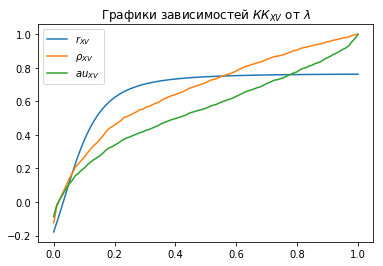

In [11]:
fig, ax = plt.subplots()
ax.set_title('Графики зависимостей $КК_{XV}$ от $\\lambda$');

lambda_values = np.linspace(0, 1, 100)

def v(l, x, y):
    return l * x.data()**3 + (1 - l) * y.data()**3

pierson_values = [
    pierson(x.data(), v(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, pierson_values, label='$r_{XV}$')

spirmen_values = [
    spirmen(x.data(), v(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, spirmen_values, label='$\\rho_{XV}$')

kendell_values = [
    kendell(x.data(), v(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, kendell_values, label='$\tau_{XV}$')

ax.legend();

### Выводы:

1. При увелечении λ увеличивается влияние случайной величины X на величину U и уменьшается влияние Y , поэтому, как видно на графиках коэффициенты корреляции растут.
2. При увелечении λ увеличивается влияние случайной величины X на величину V и уменьшается влияние Y , поэтому, как видно на графиках коэффициенты корреляции растут.

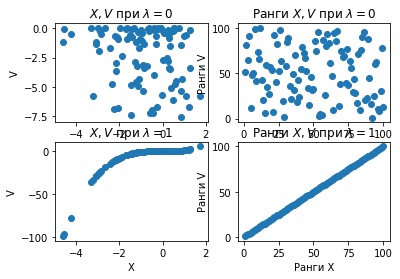

In [12]:
fig, ax = plt.subplots(2, 2)

v0 = Sample.from_data('v0', v(0, x, y))
v1 = Sample.from_data('v1', v(1, x, y))

ax[0][0].set_title('$X, V$ при $\\lambda = 0$')
ax[0][0].set_xlabel('X')
ax[0][0].set_ylabel('V')
ax[0][0].scatter(x.data(), v0.data())

ax[0][1].set_title('Ранги $X, V$ при $\\lambda = 0$')
ax[0][1].set_xlabel('Ранги X')
ax[0][1].set_ylabel('Ранги V')
ax[0][1].scatter(x.ranks(), v0.ranks())

ax[1][0].set_title('$X, V$ при $\\lambda = 1$')
ax[1][0].set_xlabel('X')
ax[1][0].set_ylabel('V')
ax[1][0].scatter(x.data(), v1.data())

ax[1][1].set_title('Ранги $X, V$ при $\\lambda = 1$')
ax[1][1].set_xlabel('Ранги X')
ax[1][1].set_ylabel('Ранги V');
ax[1][1].scatter(x.ranks(), v1.ranks())



### Выводы:

1. При λ = 0 мы видим, отстутсвие какой либо зависимости V(X)
2. При λ = 1 можно сделать вывод, что V зависит от X функционально.